# Kaggle Competition: Santander Customer Satisfaction

Contents
1. Abstract
2. Introduction
3. Data Exploration
4. Features and Feature Engineering
5. Modeling
6. Concluding Thoughts

## 1. Abstract
In this Kaggle.com Competition, given the train and test datasets provided by Santander Bank, predict which of its customers, those that are represented in the test data, are unhappy with their experience based on what can be gleaned from the train data.

## 2. Introduction
From the competition page:
> From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

> Santander Bank is asking Kagglers to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

> In this competition, you'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

Santander provides the data for competiting participants in two .csv files, plus an additional file to show how they expect the data to be submitted. Not having to dig for the data ourselves seems lovely, but there is a caveat here: Santander provides no context, let alone a data dictionary or code book, to accompany the data. Participants have only the feature names and the data itself--and to some degree one another despite this being a competition--to work with.

## 3. Data Exploration (this is gonna be long)
The files provided are '**train.csv**' and '**test.csv**' (with a third file, sample_submission.csv, to demonstrate in what format submitted predictions are required to be). The file 'train.csv' is for training the participant's model while 'test.csv' is what the participant has to test their models and predict responses accordingly.

(By the way, you should **extract train.csv.zip and test.csv.zip** into whatever folder this .ipynb is in.)

In [31]:
# import all the things
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [11]:
santrainder = pd.read_csv('train.csv')
santestder = pd.read_csv('test.csv')
print santrainder.shape
print santestder.shape

(76020, 371)
(75818, 370)


Both **train.csv** and **test.csv** are about the same size and shape, with **train.csv** having 76,020 observations and **test.csv** having 75,818. There are 370 features to sift through, and the additional 371st column in train.csv being the response vector.

For this project we focus mostly on **train.csv** as the file is what we use to train our model, but understandably the two datasets are fairly similar at a glance, with the key difference of **test.csv** not having a **response vector** (test.csv's response vector is what participants have to predict and submit for the competition).

Now, looking at the features:

In [12]:
print santrainder.columns

Index([u''ID', u'var3', u'var15', u'imp_ent_var16_ult1',
       u'imp_op_var39_comer_ult1', u'imp_op_var39_comer_ult3',
       u'imp_op_var40_comer_ult1', u'imp_op_var40_comer_ult3',
       u'imp_op_var40_efect_ult1', u'imp_op_var40_efect_ult3',
       ...
       u'saldo_medio_var33_hace2', u'saldo_medio_var33_hace3',
       u'saldo_medio_var33_ult1', u'saldo_medio_var33_ult3',
       u'saldo_medio_var44_hace2', u'saldo_medio_var44_hace3',
       u'saldo_medio_var44_ult1', u'saldo_medio_var44_ult3', u'var38',
       u'TARGET'],
      dtype='object', length=371)


... We can see that it's not in English. Santander Bank is a Spanish banking entity, one the largest banks in the eurozone, and so these features are in Spanish (*abbreviated* Spanish, no less). After some competition forum scouring and translation work, we have the following translation paradigm:

- imp_ent_varX => importe entidad => amount for the bank office
- imp_op_varX_comer => importe opcion comercial => amount for commercial option
- imp_sal_varX => importe salario => amount for wage
- ind_varX_corto => indicador corto => short (time lapse?) indicator/dummy
- ind_varX_medio => indicador medio => medium-sized (time lapse?) indicator/dummy
- ind_varX_largo => indicador largo => long-sized (time lapse?) indicator/dummy
- saldo_varX => saldo => balance
- delta_imp_amort_varX_1y3 => importe amortización 1 y 3 => amount/price for redemption (?) 1 and 3
- delta_imp_aport_varX_1y3 => importe aportación 1 y 3 => amount/price for contribution (?) 1 and 3
- delta_imp_reemb_varX_1y3 => importe reembolso 1 y 3 => amount/price for refund 1 and 3
- delta_imp_trasp_varX_out_1y3 => importe traspaso 1 y 3 => amount/price for transfer 1 and 3
- imp_venta_varX => importe venta => sale fee.
- ind_varX_emit_ult1 => indicador emitido => indicator of emission
- ind_varX_recib_ult1 => indicador recibido => indicator of reception
- num_varX_hace2 => número hace 2 => number [of variable X ] done two units in the past
- num_med_varX => número medio => mean number [of variable X]
- num_meses_varX => número de meses => number of months [for variable X]
- saldo_medio_varX => saldo medio => average balance
- delta_imp_venta_varX_1y3 = > importe de venta 1 y 3 => fee on sales [for variable X] 1 and 3

In [22]:
santrainder_en = pd.read_csv('train_english.csv')

In [24]:
print santrainder_en.columns

Index([u''ID', u'var3', u'var15', u'var16 entity amount last',
       u'var39 commercial option amount ultima1',
       u'var39 commercial option amount ultima3',
       u'var40 commercial option amount ultima1',
       u'var40 commercial option amount ultima3',
       u'var40 amount effective option ultima1',
       u'var40 amount effective option ultima3',
       ...
       u'var33 average balance hace2', u'var33 average balance hace3',
       u'var33 average balance ultima1', u'var33 average balance ultima3',
       u'var44 average balance hace2', u'var44 average balance hace3',
       u'var44 average balance ultima1', u'var44 average balance ultima3',
       u'var38', u'TARGET'],
      dtype='object', length=371)


This does help a little but not for the majority of features. There aren't really any hints as to what different '**varX**' mean (X being any positive integer between 3 and 46) right off the bat, but when looking at the data itself it's easy enough to tell from a glance which features are **categorical or numerical** (for the most part, anyway), and it is possible to guess the nature of certain features/variables by looking at their respective **histogram**, basic .describe() stats (**mean, median, mode, etc.**), and/or other measures.

But even without translation, it's clear there are contextually **different types of features**.

For visual simplicity's sake, when we're looking at data we'll be using the original abbreviated Spanish data, but when it comes to context we'll use English (noting its original Spanish when needed for clarity and vice versa).

### imp_ent_varX (amount for the bank office)
There is only one int_ent_varX feature, and it's imp_ent_var16_ult1.

[Insert elaboration here if any]

In [53]:
print santrainder.imp_ent_var16_ult1.describe()
santrainder.imp_ent_var16_ult1.value_counts()[0:6]

count     76020.000000
mean         86.208265
std        1614.757313
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      210000.000000
Name: imp_ent_var16_ult1, dtype: float64


0.0       72301
300.0       221
150.0       217
600.0       172
900.0       164
3.0         141
450.0       124
60.0        123
1500.0      119
90.0        112
30.0         97
1200.0       89
3000.0       76
120.0        74
15.0         65
750.0        61
180.0        56
1800.0       56
210.0        55
360.0        46
240.0        42
1050.0       42
75.0         31
2400.0       31
6000.0       29
420.0        29
2100.0       28
270.0        25
480.0        23
660.0        22
390.0        21
45.0         21
1350.0       21
4500.0       19
3600.0       19
9000.0       19
960.0        18
1650.0       18
2700.0       18
1950.0       17
6.0          17
Name: imp_ent_var16_ult1, dtype: int64

### imp_op_varX (amount for ____ option)
There are 15 total of these, but there are different subcategories within this feature type, penultimate suffices either **comer** ('commercial') or **efect** ('effect'), and ultimate suffices are **ultY** ('last', Y is either 1 or 3). The Xs in **VarX** here range from 39 to 41.

[Insert elaboration here if any]

In [52]:
print santrainder.columns[4:19]

Index([u'imp_op_var39_comer_ult1', u'imp_op_var39_comer_ult3',
       u'imp_op_var40_comer_ult1', u'imp_op_var40_comer_ult3',
       u'imp_op_var40_efect_ult1', u'imp_op_var40_efect_ult3',
       u'imp_op_var40_ult1', u'imp_op_var41_comer_ult1',
       u'imp_op_var41_comer_ult3', u'imp_op_var41_efect_ult1',
       u'imp_op_var41_efect_ult3', u'imp_op_var41_ult1',
       u'imp_op_var39_efect_ult1', u'imp_op_var39_efect_ult3',
       u'imp_op_var39_ult1'],
      dtype='object')


### ind_varX (indicator)
There are 67 total features that are '**indicator**' features with dummy values of either 0 or 1:

In [28]:
print santrainder.columns[20:87]
print santrainder['ind_var1_0'].value_counts() # example
print santrainder['ind_var1'].value_counts() # example

Index([u'ind_var1_0', u'ind_var1', u'ind_var2_0', u'ind_var2', u'ind_var5_0',
       u'ind_var5', u'ind_var6_0', u'ind_var6', u'ind_var8_0', u'ind_var8',
       u'ind_var12_0', u'ind_var12', u'ind_var13_0', u'ind_var13_corto_0',
       u'ind_var13_corto', u'ind_var13_largo_0', u'ind_var13_largo',
       u'ind_var13_medio_0', u'ind_var13_medio', u'ind_var13', u'ind_var14_0',
       u'ind_var14', u'ind_var17_0', u'ind_var17', u'ind_var18_0',
       u'ind_var18', u'ind_var19', u'ind_var20_0', u'ind_var20',
       u'ind_var24_0', u'ind_var24', u'ind_var25_cte', u'ind_var26_0',
       u'ind_var26_cte', u'ind_var26', u'ind_var25_0', u'ind_var25',
       u'ind_var27_0', u'ind_var28_0', u'ind_var28', u'ind_var27',
       u'ind_var29_0', u'ind_var29', u'ind_var30_0', u'ind_var30',
       u'ind_var31_0', u'ind_var31', u'ind_var32_cte', u'ind_var32_0',
       u'ind_var32', u'ind_var33_0', u'ind_var33', u'ind_var34_0',
       u'ind_var34', u'ind_var37_cte', u'ind_var37_0', u'ind_var37',
       u'i

And from these indicator features we can see that they often come in pairs of **ind_varX** and **ind_varX_0**. It's speculated that each of these indicator varXs is some sort of banking feature, service, or product, and the suffix **0** suggests an explicit opt-out of the product (vs. simply not having used the product before)

### num_varX (number)
There a lot of these.
Yada yada, might be number of products, I need to look at these some more.

### saldo_varX (balance)
There are 71 features that are prefixed with saldo.

In [ ]:
print santrainder.columns[20:87]

### varX (just varX, plain and simply)
No prefix, no suffix, no other descriptors, they are **var3, var15, var36, and var38**. Which are contextually more interesting than the rest, I like to think, probably because they're less daunting somehow and I'm not afraid of them.

var3 is nationality, var 15 is age, var36 is still up in the air, and var38 is possibly mortgage value

#### var3 is nationality
I don't actually understand why var3 is nationality, but it seems to be accepted in the forums. One user [commented](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19367/var3/111169#post111169) that the distribution of categories/countries matches what they expect from a bank of this caliber. Each category from 1 to 238 represents a different country, with country 2 having the most customers represented in this data set.

In [63]:
print santrainder.var3.describe()
santrainder.var3.value_counts()[0:20]

count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64


 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
 6            82
 0            75
 10           72
 11           66
 5            63
 14           61
 15           34
 18           10
 16            9
 17            7
Name: var3, dtype: int64

var3 is entirely positive (as categorical variables are wont to be) save for the one hundred seventeen -999999s. These clearly represent errors or unknowns. We can either remove these entries or replace them with the mode and remember to do the same with the test data.

In [74]:
# var3 error -999999, 117 of them
# 117/77060 = 0.0015 (not even 1% of the entries)
# drop as null or replace with mode (category 2)?
santrainder = santrainder.replace(-999999,2) 

#### var15 is age
The histogram of var15 is pretty obviously age, and the spike for the 20-25 range coincides with [Santander having had a campaign targeted at university students](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19291/data-dictionary/110414#post110414) some time ago.

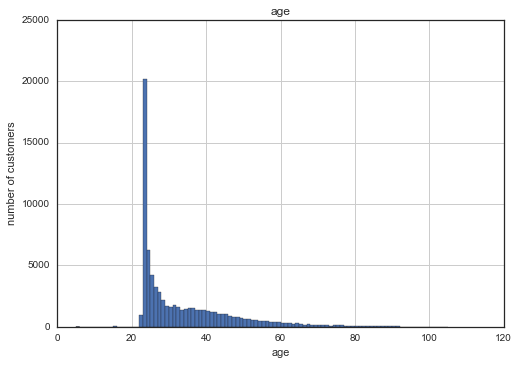

In [61]:
# age distribution
santrainder.var15.hist(bins=100)
plt.xlabel('age')
plt.ylabel('number of customers')
plt.title('age')
plt.show()

#### var38 is either total asset worth or mortgage value
The **mean of var38** is 117235.81, and [Spain's average mortgage was 118000 euros in 2011 and was 105000 in 2015.](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19895/var38-is-mortgage-value)
[Insert elaboration here. Looking for actual resources to back this up or disprove it but low priority as knowing isn't necessarily... necessary for modeling.]

In [62]:
# total asset worth or mortgage value
santrainder.var38.describe()

count    7.602000e+04
mean     1.172358e+05
std      1.826646e+05
min      5.163750e+03
25%      6.787061e+04
50%      1.064092e+05
75%      1.187563e+05
max      2.203474e+07
Name: var38, dtype: float64

var38 also has a terrible distribution to look at, since there's a wide range of magnitude orders under this feature. Log scaling makes it easier on the eyes.

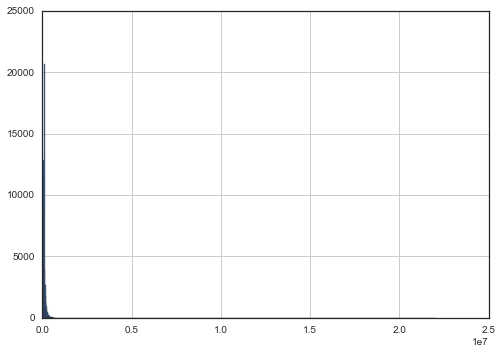

In [82]:
# histogram of original var38
santrainder.var38.hist(bins=1000);

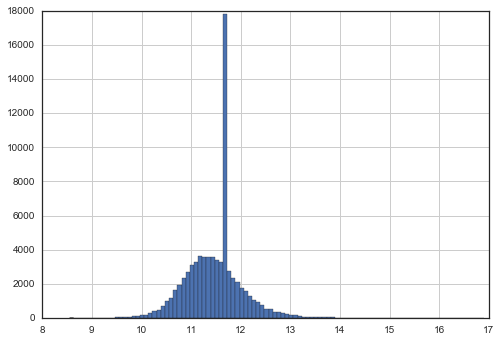

In [87]:
# wide range of magnitude orders => log scaling
santrainder['var38_log'] = santrainder['var38'].map(np.log)
santrainder.var38_log.hist(bins=100)

16.9081308005
47166.0


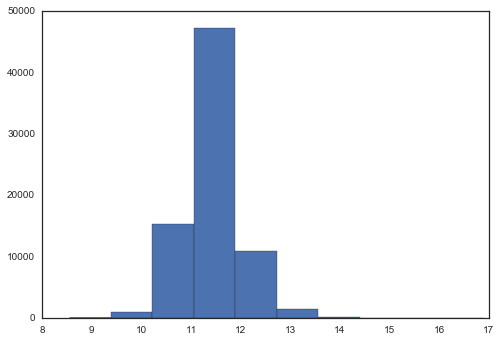

In [90]:
# What is that random spike there?
y_hst, x_hst, _ = plt.hist(santrainder.var38_log)
print x_hst.max()
print y_hst.max()

In [92]:
np.exp(x_hst.max())

22034738.759999976

## 4. Features and Feature Engineering (this might be even longer)

In [77]:
santrainder.var3.value_counts()[0:20]

2     74281
8       138
9       110
3       108
1       105
13       98
7        97
4        86
12       85
6        82
0        75
10       72
11       66
5        63
14       61
15       34
18       10
16        9
23        7
17        7
Name: var3, dtype: int64

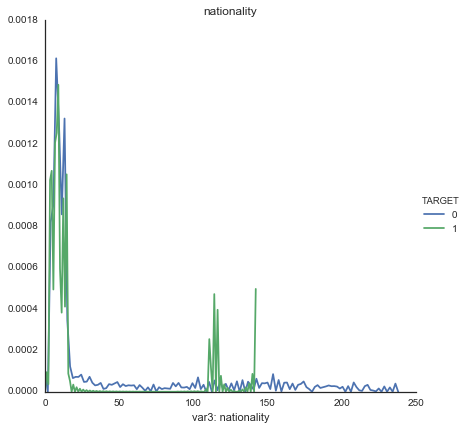

In [79]:
# var3 kernel density estimation (probability density function) because histogram is weird
sns.FacetGrid(santrainder, hue='TARGET', size=6) \
   .map(sns.kdeplot, 'var3') \
   .add_legend()
plt.title('nationality');
plt.xlabel('var3: nationality');
# There might be something to living in a country in the category 110-140 range.

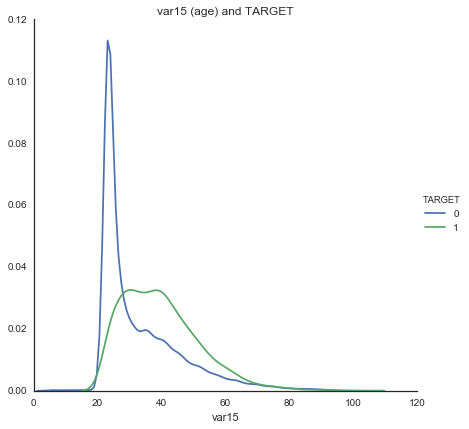

In [69]:
# var15 (age), kernel density estimate plot because it's also easier to read than a histogram
sns.FacetGrid(santrainder, hue='TARGET', size=6) \
   .map(sns.kdeplot, "var15") \
   .add_legend()
plt.title('var15 (age) and TARGET');

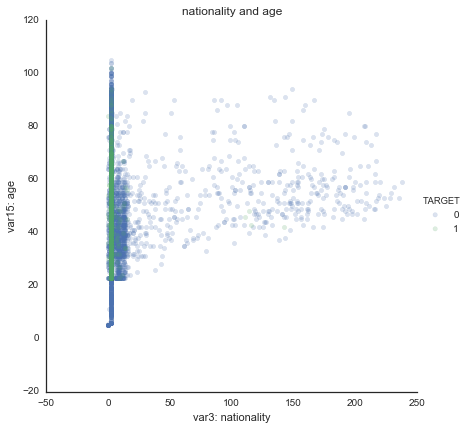

In [81]:
sns.FacetGrid(santrainder, hue='TARGET', size=6) \
   .map(plt.scatter, 'var3', 'var15', alpha = 0.2) \
   .add_legend()
plt.title('nationality and age');
plt.xlabel('var3: nationality');
plt.ylabel('var15: age');

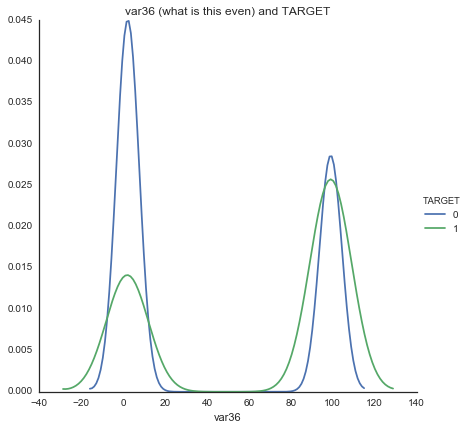

In [72]:
# I don't know what var36 is other than it's probably categorical
# but there is some sort of relationship with TARGET
sns.FacetGrid(santrainder, hue='TARGET', size=6) \
   .map(sns.kdeplot, 'var36') \
   .add_legend()
plt.title('var36 (what is this even) and TARGET');

## 5. Modeling
The response is a binary output, so it stands to reason that **logistic regression** is the most appropriate estimator to use.

In [ ]:
feature_cols = []
X = santrainder[feature_cols]
y = 

## 6. Concluding Thoughts